### Load data set with features

In [5]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [10]:
run all_functions.py

In [11]:
run features.py

In [5]:
import json

In [13]:
def create_predictions_size(df, dfc, all_homes, appliance_min, national_average, appliance="hvac", feature=['num_rooms', 'total_occupants'], NUM_NEIGHBOURS=2,
                       train_outlier=True, test_outlier=False, outlier_features=None, outlier_fraction=0.1, size=10):




    out_month = {}
    gt_month = {}
    overall_dfs = {}
    df_pred_copy = df.copy()
    #df_pred_copy = dfs[appliance].copy()
    df_pred_copy = df_pred_copy.ix[all_homes[appliance]]
    if appliance=="hvac":
        start_month, end_month = 5, 11
    else:
        start_month, end_month = 1, 13

    if test_outlier:
        # We now need to remove the test outlier homes
        if outlier_features is None:
            print("Cannot proceeed further")
            raise
        else:
            outlier_test_homes = find_outlier_test_homes(df,all_homes,  appliance,
                                                         outlier_features, outliers_fraction=0.1)


    for month_num in range(start_month, end_month):
        month_appliance = "%s_%d" %(appliance, month_num)
        y = df_pred_copy[month_appliance]
        y2 = y.dropna()
        y3 = y2[y2>appliance_min[appliance]].dropna()
        df3 = df_pred_copy[feature].ix[y3.index].dropna()

        #df3 = df.ix[y3.index].dropna()
        y3 = y3.ix[df3.index]
        #df3 = df3.ix[appliance_fhmm[appliance].index].dropna()
        #y3 = y3.ix[df3.index]
        from sklearn.cross_validation import LeaveOneOut
        from sklearn.neighbors import RadiusNeighborsRegressor
        #clf = RadiusNeighborsRegressor(radius=k)
        clf = KNeighborsRegressor(n_neighbors=NUM_NEIGHBOURS)
        #clf = KNeighborsRegressor(n_neighbors=k, weights = 'distance' )
        loo = LeaveOneOut(len(df3))
        out_pred = []


        for train, test in loo:
            if test_outlier:
                test_home_num = y3.index.values[test]

                if test_home_num in outlier_test_homes:
                    continue


            if train_outlier:
                outlier_homes, inlier_homes = find_outlier_train(y3.ix[y3.index.values[train]])

            else:
                inlier_homes = deepcopy(y3.ix[y3.index.values[train]])
            #clf.fit(preprocessing.normalize(df3[feature_columns[feature]].values[train]), y3.values[train])

            if size>=len(inlier_homes):
                indices_random = range(len(inlier_homes))
            else:
                total_size = len(inlier_homes)
                indices_random = np.random.choice(total_size, size)
            
            clf.fit(df3[feature].ix[inlier_homes.index].values[indices_random], inlier_homes.values[indices_random])
            #out_pred.append(clf.predict(preprocessing.normalize(df3[feature_columns[feature]].values[test])))
            out_pred.append(clf.predict(df3[feature].values[test]))

        out_pred = np.hstack(out_pred)

        out_month[month_num] = out_pred

        if test_outlier:
            non_test_outlier_index = np.setdiff1d(y3.index.values, np.array(outlier_test_homes))
            gt_month[month_num] = y3.ix[non_test_outlier_index].values
            overall_dfs[month_num] = pd.DataFrame({"gt":y3.ix[non_test_outlier_index].values, "pred":out_pred,
                                                  "gt_total":dfc.ix[non_test_outlier_index]["aggregate_"+str(month_num)].values}, index=non_test_outlier_index)
            overall_dfs[month_num]["national average"] = overall_dfs[month_num]["gt_total"]*national_average[appliance]
        else:
            gt_month[month_num] = y3.values
            overall_dfs[month_num] = pd.DataFrame({"gt":y3.values, "pred":out_pred,
                                                  "gt_total":dfc.ix[y3.index]["aggregate_"+str(month_num)].values}, index=y3.index)
            overall_dfs[month_num]["national average"] = overall_dfs[month_num]["gt_total"]*national_average[appliance]



    return overall_dfs

In [2]:
import json

optimal_dict_median_overall = json.load(open("optimal_dict_cv1.json",'r'))
optimal_dict_mean_overall = json.load(open("optimal_cv2.json",'r'))


In [3]:
optimal_dict_mean_overall['dr']['All']['dr']['All']


{u'accuracy': 46.67661515555978,
 u'f': [u'disag_fridge', u'aggregate_12', u'total_occupants', u'fft_2'],
 u'k': 5}

In [44]:
len(all_homes['dw'])

26

In [54]:
np.random.seed(0)
import sys
NUM_ROUNDS= 5
out_appliance = {}
for appliance_name in optimal_dict_median_overall.iterkeys():
    print "*"*20
    print appliance_name
    optimal_k = optimal_dict_mean_overall[appliance_name]['All'][appliance_name]['All']['k']
    optimal_f = optimal_dict_mean_overall[appliance_name]['All'][appliance_name]['All']['f']
    train_outlier_f  = optimal_dict_median_overall[appliance_name]['All']['f']
    
    out_appliance[appliance_name] = {}
    for random_seed in range(NUM_ROUNDS):
        
        print "Round", random_seed, "of", NUM_ROUNDS
        sys.stdout.flush()
        out_appliance[appliance_name][random_seed]={}
        for size in range(optimal_k, 34):
            
            try:
                temp = create_predictions_size(df, dfc, all_homes, appliance_min,
                                          national_average, appliance=appliance_name, 
                                          feature=optimal_f,
                                          NUM_NEIGHBOURS=optimal_k, train_outlier=True, test_outlier=True,
                                          outlier_features=train_outlier_f, outlier_fraction=0.1, size=size)


                errors = {}
                if appliance_name =="hvac":
                    start_month, end_month = 5, 11
                else:
                    start_month, end_month = 1, 13
                for i in range(start_month, end_month):
                    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
                error_df = pd.DataFrame(errors)
                accur_df = 100-error_df
                accur_df[accur_df<0]=0
                tdf = accur_df
                if appliance_name =="hvac":
                    for home in [624, 1953, 6636, 6836, 7769, 9922]:
                        tdf.loc[home, 5]=np.NaN
                        tdf.loc[home, 10]=np.NaN
    
                out_appliance[appliance_name][random_seed][size] = tdf.dropna().mean().mean()
                
            except Exception, e:
                print e
                print "pass", size
                pass


********************
hvac
Round 0 of 5
Round 1 of 5
Round 2 of 5
Round 3 of 5
Round 4 of 5
********************
light
Round 0 of 5
Round 1 of 5
Round 2 of 5
Round 3 of 5
Round 4 of 5
********************
wm
Round 0 of 5
Round 1 of 5
Round 2 of 5
Round 3 of 5
Round 4 of 5
********************
fridge
Round 0 of 5
Round 1 of 5
Round 2 of 5
Round 3 of 5
Round 4 of 5
********************
dw
Round 0 of 5
Round 1 of 5
Round 2 of 5
Round 3 of 5
Round 4 of 5
********************
dr
Round 0 of 5
Round 1 of 5
Round 2 of 5
Round 3 of 5
Round 4 of 5


In [55]:
output = {}
for appliance_name, appliance_results in out_appliance.iteritems():
    output[appliance_name] = pd.Series(appliance_results[0])
    tot = len(appliance_results)
    for i in range(1, tot):
        output[appliance_name] = output[appliance_name] + pd.Series(appliance_results[i])

output_df = pd.DataFrame(output)
output_df = output_df.div(tot)

In [2]:
#output_df.to_csv("sensitivity_num_homes.csv")
output_df = pd.read_csv("sensitivity_num_homes.csv", index_col=0)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from common_functions import latexify, format_axes

In [5]:
latexify()

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [10]:
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

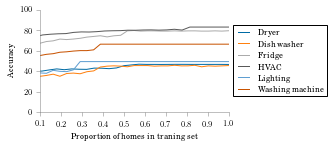

In [16]:
appliance_name_mapping = {"dr": "Dryer", "wm": "Washing machine",
                          "fridge":"Fridge","light":"Lighting",
                          "hvac":"HVAC","dw":"Dish washer"}

normalised_output = {}
fig, ax = plt.subplots(1,1)
for i, appliance_name in enumerate(output_df.columns):
    temp = output_df[appliance_name].dropna()
    temp.index= np.linspace(0, 1, len(output_df[appliance_name].dropna()))
    normalised_output[appliance_name] = temp
    pd.Series(normalised_output[appliance_name]).plot(ax=ax, label=appliance_name_mapping[appliance_name], 
                                                      color=tableau20blind[i])
plt.xlim((0.1,1.))
plt.ylim((0, 100))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.xlabel("Proportion of homes in traning set")
plt.ylabel("Accuracy")
format_axes(plt.gca())
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity_num_homes.png",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity_num_homes.pdf",bbox_inches="tight")

In [50]:
normalised_output_df = pd.DataFrame(normalised_output)